In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, prange
import cython

In [2]:
data = pd.read_csv("processed_database_2.csv", low_memory=False)
data.reset_index(drop=True, inplace=True)

# data = data.sample(n=100000)

# Train/Test Split
data_train = data.sample(frac=0.8)
data_test = data.drop(data_train.index)

X_train = data_train.iloc[:, 1:].reset_index(drop=True)
X_test = data_test.iloc[:, 1:].reset_index(drop=True)

Y_train = data_train.iloc[:, :1].values
Y_test = data_test.iloc[:, :1].values

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(469338, 15) (469338, 1) (117334, 15) (117334, 1)


In [3]:
@jit(nopython=True)
def mse(Y_true: np.ndarray, Y_pred: np.ndarray):
    return np.square(Y_true - Y_pred).mean()

In [4]:
@jit(nopython=True)
def find_best_split(X: np.ndarray, Y: np.ndarray):
    best_feature, best_threshold, best_error = None, None, np.inf
    for feature_idx in prange(X.shape[1]):
        feature_values = X[:, feature_idx]
        feature_values.sort()
        for threshold in feature_values:
            Y_left = Y[X[:, feature_idx] <= threshold]
            Y_right = Y[X[:, feature_idx] > threshold]

            if len(Y_left) == 0 or len(Y_right) == 0:
                continue

            error_left = mse(Y_left, np.mean(Y_left))
            error_right = mse(Y_right, np.mean(Y_right))
            weighted_error = len(Y_left) * error_left + len(Y_right) * error_right

            if weighted_error < best_error:
                best_error = weighted_error
                best_feature = feature_idx
                best_threshold = threshold
                break  # Break out of the loop once the best error is found

    return best_feature, best_threshold

In [5]:
def find_best_split(X: pd.DataFrame, Y: pd.DataFrame):
    best_feature, best_threshold, best_error = None, None, float("inf")
    for feature_label in X.columns.tolist():
        X_sorted = X.sort_values(feature_label)
        feature_values = X_sorted[feature_label]
        for threshold in feature_values:
            Y_left = Y[X_sorted[feature_label] <= threshold]
            Y_right = Y[X_sorted[feature_label] > threshold]

            if len(Y_left) == 0 or len(Y_right) == 0:
                continue

            error_left = mse(Y_left, np.mean(Y_left))
            error_right = mse(Y_right, np.mean(Y_right))
            weighted_error = len(Y_left) * error_left + len(Y_right) * error_right

            if weighted_error < best_error:
                best_error = weighted_error
                best_feature = feature_label
                best_threshold = threshold

    return best_feature, best_threshold

In [6]:
@jit(nopython=True)
def find_best_split(X: np.ndarray, Y: np.ndarray):
    best_feature, best_threshold, best_error = None, None, np.inf
    for feature_idx in range(X.shape[1]):
        # features = np.sort(features)
        for threshold in X[:, feature_idx]:
            Y_left = Y[X[:, feature_idx] <= threshold]
            Y_right = Y[X[:, feature_idx] > threshold]

            if len(Y_left) == 0 or len(Y_right) == 0:
                continue

            error_left = mse(Y_left, np.mean(Y_left))
            error_right = mse(Y_right, np.mean(Y_right))
            weighted_error = len(Y_left) * error_left + len(Y_right) * error_right

            if weighted_error < best_error:
                best_error = weighted_error
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold

In [7]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self._depth = 0
        self._tree = None

    def _build_three(self, X: np.ndarray, Y: pd.DataFrame, depth=0, verbose=False):
        self._depth = max(self._depth, depth)

        if verbose:
            print(f"Current Depth: {depth}, Max Depth: {self._depth}        ", end="\r")

        if depth >= self.max_depth or len(np.unique(Y)) == 1:
            return np.mean(Y)

        feature, threshold = find_best_split(X, Y)
        if feature is None:
            return np.mean(Y)

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        left_child = self._build_three(
            X[left_mask], Y[left_mask], depth + 1, verbose=verbose
        )
        right_child = self._build_three(
            X[right_mask], Y[right_mask], depth + 1, verbose=verbose
        )

        return {
            "feature": feature,
            "threshold": threshold,
            "left": left_child,
            "right": right_child,
        }

    def fit(self, X: pd.DataFrame, Y: np.ndarray, verbose=False):
        X = X.to_numpy()
        self._depth = 0
        self._tree = self._build_three(X, Y, verbose=verbose)

    def _predict_single(self, sample, node=None):
        if node is None:
            node = self._tree
        if not isinstance(node, dict):
            return node

        feature, threshold = node["feature"], node["threshold"]

        if sample[feature] <= threshold:
            return self._predict_single(sample, node["left"])
        else:
            return self._predict_single(sample, node["right"])

    def predict(self, X: pd.DataFrame):
        X = X.to_numpy()
        pred = np.apply_along_axis(self._predict_single, axis=1, arr=X)
        """pred = np.array(
            [self._predict_single(sample, self._tree) for sample in X]
        )"""
        return pred.reshape(pred.shape[0], 1)

In [8]:
X_train_ = X_train.sample(10000)
Y_train_ = Y_train[X_train_.index]

regressor = DecisionTree(max_depth=np.inf)
regressor.fit(X_train_, Y_train_, verbose=True)

Training cost: 361.08


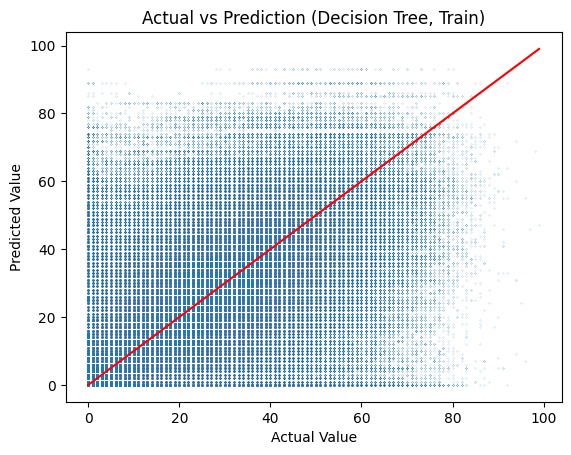

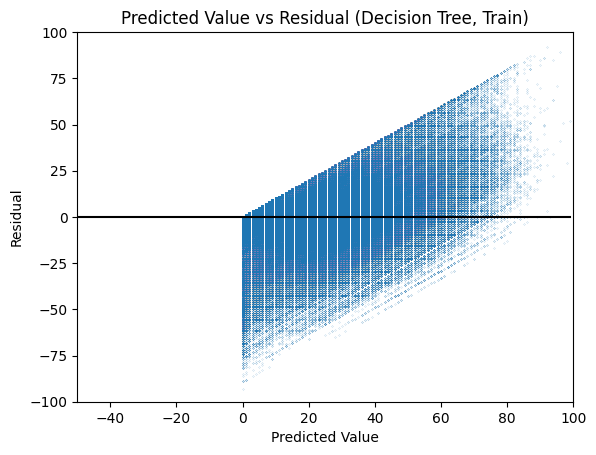

In [9]:
Y_pred_train = regressor.predict(X_train)
residuals_train = Y_train - Y_pred_train
train_cost = mse(Y_train, Y_pred_train)
print(f"Training cost: {np.squeeze(train_cost).round(2)}")

fig, ax = plt.subplots()
ax.scatter(Y_train, Y_pred_train, (0.01))
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
ax.set_title("Actual vs Prediction (Decision Tree, Train)")

ax.plot(np.arange(100), np.arange(100), "r")
fig.savefig("tree_train_pred_inf")


fig, ax = plt.subplots()
ax.set_autoscale_on(False)
ax.scatter(Y_train, residuals_train, (0.01))
ax.set_xbound(-50, 100)
ax.set_ybound(-100, 100)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residual")
ax.set_title("Predicted Value vs Residual (Decision Tree, Train)")

ax.plot(np.arange(150)-50, np.zeros((150,)), "black")

fig.savefig("tree_train_resd_inf")

Training cost: 366.73


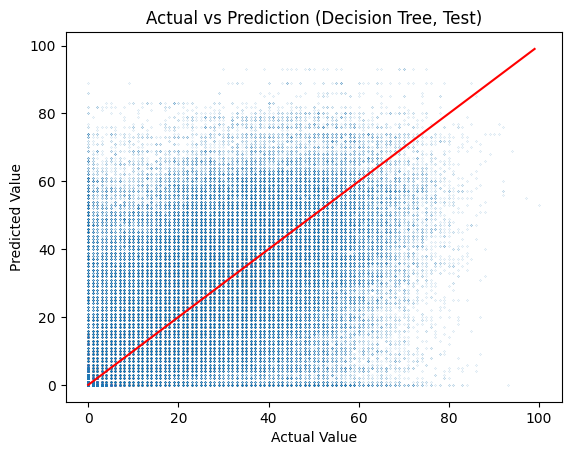

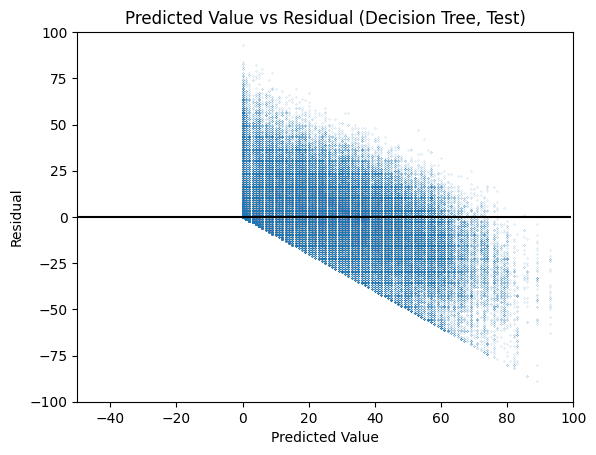

In [10]:
Y_pred_test = regressor.predict(X_test)
residuals_test = Y_test - Y_pred_test
test_cost = mse(Y_test, Y_pred_test)
print(f"Training cost: {np.squeeze(test_cost).round(2)}")

fig, ax = plt.subplots()
ax.scatter(Y_test, Y_pred_test, (0.01))
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
ax.set_title("Actual vs Prediction (Decision Tree, Test)")

ax.plot(np.arange(100), np.arange(100), "r")
fig.savefig("tree_test_pred_inf")


fig, ax = plt.subplots()
ax.set_autoscale_on(False)
ax.scatter(Y_pred_test, residuals_test, (0.01))
ax.set_xbound(-50, 100)
ax.set_ybound(-100, 100)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residual")
ax.set_title("Predicted Value vs Residual (Decision Tree, Test)")

ax.plot(np.arange(150)-50, np.zeros((150,)), "black")

fig.savefig("tree_test_resd_inf")

In [11]:
class RandomForest:
    def __init__(self, n_trees, max_depth):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self._trees: list[DecisionTree,] = []
        
    def fit(self, X: pd.DataFrame, Y: pd.DataFrame, verbose=False):
        self.trees = []
        for i in range(self.n_trees):
            if (verbose):
                print(f"\nTree: {i+1}/{self.n_trees}")
            
            sample_idxs = np.random.choice(np.arange(X.shape[0]), int((X.shape[0]*1.1)/self.n_trees), replace=True)
            
            tree = DecisionTree(max_depth=self.max_depth)
            X_sample = X.reset_index(drop=True).sample(int((X.shape[0]*1.1)/self.n_trees))
            Y_sample = Y[X_sample.index]
            tree.fit(X_sample, Y_sample, verbose=verbose)
            self._trees.append(tree)
        
    
    def predict(self, X: pd.DataFrame):
        tree_preds = np.array([tree.predict(X) for tree in self._trees])
        return tree_preds.mean(axis=0)

In [12]:
forest = RandomForest(n_trees=100, max_depth=np.inf)
forest.fit(X_train_, Y_train_, verbose=True)


Tree: 1/100
Current Depth: 5, Max Depth: 11         
Tree: 2/100
Current Depth: 5, Max Depth: 16         
Tree: 3/100
Current Depth: 4, Max Depth: 14         
Tree: 4/100
Current Depth: 3, Max Depth: 15         
Tree: 5/100
Current Depth: 5, Max Depth: 15         
Tree: 6/100
Current Depth: 3, Max Depth: 13         
Tree: 7/100
Current Depth: 6, Max Depth: 13         
Tree: 8/100
Current Depth: 3, Max Depth: 19         
Tree: 9/100
Current Depth: 4, Max Depth: 14         
Tree: 10/100
Current Depth: 5, Max Depth: 16         
Tree: 11/100
Current Depth: 4, Max Depth: 15         
Tree: 12/100
Current Depth: 5, Max Depth: 12         
Tree: 13/100
Current Depth: 5, Max Depth: 13         
Tree: 14/100
Current Depth: 4, Max Depth: 14         
Tree: 15/100
Current Depth: 5, Max Depth: 15         
Tree: 16/100
Current Depth: 4, Max Depth: 13         
Tree: 17/100
Current Depth: 5, Max Depth: 16         
Tree: 18/100
Current Depth: 5, Max Depth: 12         
Tree: 19/100
Current Depth: 3, Max D

Training cost: 200.1


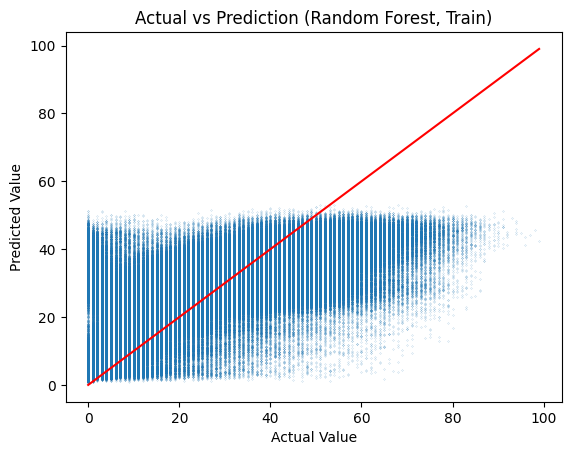

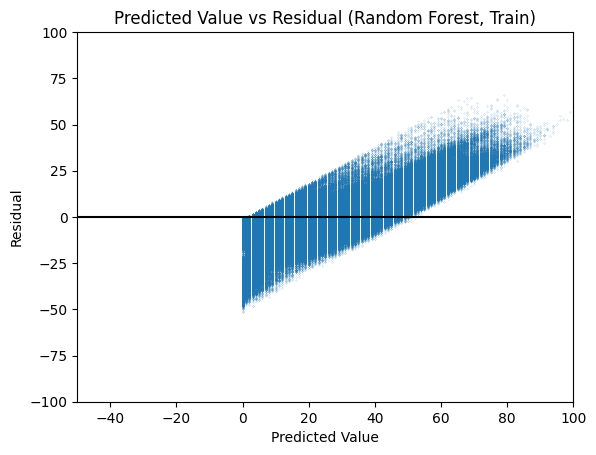

In [13]:
Y_pred_train = forest.predict(X_train)
residuals_train = Y_train - Y_pred_train
train_cost = mse(Y_train, Y_pred_train)
print(f"Training cost: {np.squeeze(train_cost).round(2)}")

fig, ax = plt.subplots()
ax.scatter(Y_train, Y_pred_train, (0.01))
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
ax.set_title("Actual vs Prediction (Random Forest, Train)")

ax.plot(np.arange(100), np.arange(100), "r")
fig.savefig("forest_train_pred_inf")


fig, ax = plt.subplots()
ax.set_autoscale_on(False)
ax.scatter(Y_train, residuals_train, (0.01))
ax.set_xbound(-50, 100)
ax.set_ybound(-100, 100)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residual")
ax.set_title("Predicted Value vs Residual (Random Forest, Train)")

ax.plot(np.arange(150)-50, np.zeros((150,)), "black")

fig.savefig("forest_train_resd_inf")

Training cost: 199.24


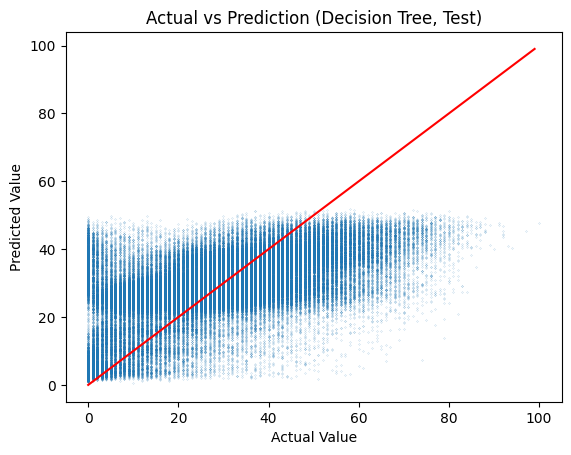

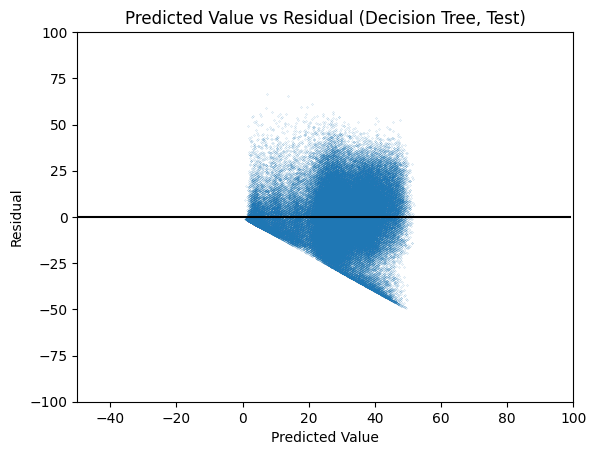

In [14]:
Y_pred_test = forest.predict(X_test)
residuals_test = Y_test - Y_pred_test
test_cost = mse(Y_test, Y_pred_test)
print(f"Training cost: {np.squeeze(test_cost).round(2)}")

fig, ax = plt.subplots()
ax.scatter(Y_test, Y_pred_test, (0.01))
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
ax.set_title("Actual vs Prediction (Decision Tree, Test)")

ax.plot(np.arange(100), np.arange(100), "r")
fig.savefig("forest_test_pred_inf")


fig, ax = plt.subplots()
ax.set_autoscale_on(False)
ax.scatter(Y_pred_test, residuals_test, (0.01))
ax.set_xbound(-50, 100)
ax.set_ybound(-100, 100)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residual")
ax.set_title("Predicted Value vs Residual (Decision Tree, Test)")

ax.plot(np.arange(150)-50, np.zeros((150,)), "black")

fig.savefig("forest_test_resd_inf")